In [2]:
import os
os.chdir('C:/Users/KAI/Coding/DeepAR_InfluenzaForecast')
# from PythonFiles.model import model, preprocessing, split_forecasts_by_week, forecast_by_week, train_test_split
# from PythonFiles.PlottingFunctions import plot_coverage, print_forecasts_by_week,hyperparameter_boxplots,plot_model_results_by_hp, hp_color_plot
# from PythonFiles.Configuration import Configuration
import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from datetime import datetime
# from gluonts.mx import Trainer, DeepAREstimator
# from gluonts.dataset.pandas import PandasDataset
# from PythonFiles.rolling_dataset import generate_rolling_dataset,StepStrategy
# from gluonts.evaluation import make_evaluation_predictions, Evaluator
# # import ray
# # from ray.air import session
# # from ray import tune
# import itertools
# import matplotlib.dates as mdates
# from gluonts.mx.distribution import NegativeBinomialOutput
# config = Configuration()
influenza_df = pd.read_csv("Notebooks/DataProcessing/influenza.csv", sep=',')
population_df = pd.read_csv("Notebooks/DataProcessing/PopulationVector.csv", sep=',')
neighbourhood_df = pd.read_csv("Notebooks/DataProcessing/AdjacentMatrix.csv", sep=',', index_col=0)

In [1]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.pandas import PandasDataset
def preprocessing(config, df, check_count=False, output_type="PD"):
    """
    This function processes the data into different formats based on the specified output type.
    
    Parameters:
        config (object): Configuration object.
        df (pandas.DataFrame): Input data with a 'date' column and other relevant information.
        check_count (bool, optional): If True, it returns a dictionary with counts of observations for each location.
                                      Defaults to False.
        output_type (str, optional): The type of output format. 
                                     Options are "PD" (PandasDataset), "LD" (ListDataset), or "corrected_df" (pandas DataFrame).
                                     Defaults to "PD".
    
    Returns:
        pandas.DataFrame or gluonts.dataset.pandas.PandasDataset or gluonts.dataset.common.ListDataset:
            The processed data in the specified output format.
        dict or None: If check_count is True, it returns a dictionary with counts of observations for each location.

    """

    # Convert the 'date' column to datetime and set it as the DataFrame index
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    if check_count:
        count_dict = {}
        for location in df.location.unique():
            # Save the number of values within the training & testing time period into the count_dict
            location_df = df.loc[(df['location'] == location) & (df.index > config.train_start_time) & (df.index <= config.test_end_time), :]
            count_dict[location] = location_df.shape[0]
        
        # Print out the distribution of each region with missing values
        print('LK mit weniger als' + str(max(count_dict.values())))
        missing_values_dict = {k: v for k, v in count_dict.items() if v < max(count_dict.values())}
        print(missing_values_dict)
        
        # Return the DataFrame and missing_values_dict if check_count is True
        return df, missing_values_dict
    
    if output_type in ['PD', 'LD', 'corrected_df']:
        # Create a DataFrame Blueprint with evenly spaced time index
        start, end = min(df.index), max(df.index)
        correctly_spaced_index = pd.date_range(start=start, end=end, freq=config.parameters["freq"])
        correctly_spaced_location_df = pd.DataFrame(index=correctly_spaced_index)
        correctly_spaced_df = pd.DataFrame()
        location_list = df.loc[:, 'location'].unique()
        
        for location in location_list:
            # Fill in the missing time steps and locations
            temporary_df = correctly_spaced_location_df.join(df.loc[df.location == location])
            temporary_df['location'] = temporary_df['location'].fillna(location)
            correctly_spaced_df = pd.concat([correctly_spaced_df, temporary_df])
        
        if output_type == "PD":
            # Convert to PandasDataset format
            df = PandasDataset.from_long_dataframe(dataframe=correctly_spaced_df, item_id='location', target="value", freq=config.parameters["freq"])
        elif output_type == "LD":
            # Convert to ListDataset format
            df = ListDataset([{"start": min(correctly_spaced_index), "target": correctly_spaced_df.loc[correctly_spaced_df.location == location, 'value']}
                              for location in location_list], freq=config.parameters["freq"])
        elif output_type == "corrected_df":
            # Return the corrected DataFrame
            return correctly_spaced_df
    
    # Return the processed data
    return df

c:\Users\KAI\Coding\DeepAR_InfluenzaForecast\venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [4]:
from PythonFiles.Configuration import Configuration
config = Configuration()
data_splits_dict = {}
output_dict = {}

locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date','week']]
df = preprocessing(config, df, check_count=False, output_type="corrected_df")
for location in locations:
    df.loc[df.location == location, "population"] = int(population_df.loc[population_df.Location == location, "2011"].values[0])
    df.loc[df.location == location, locations] = neighbourhood_df.loc[neighbourhood_df.index==location,locations].values[0].astype(int)

ModuleNotFoundError: No module named 'mxnet'

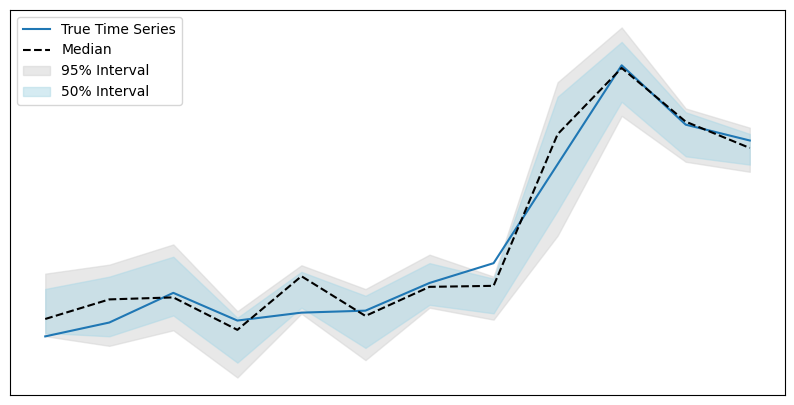

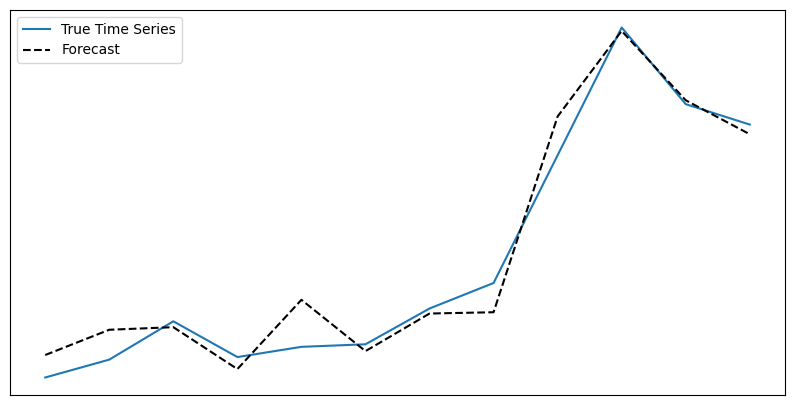

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# True time series
ts = [3.3, 4, 5.5, 4.1, 4.5, 4.6, 6, 7, 12, 17, 14, 13.2]

# Add random noise to the median
median_noise = np.random.normal(0, 1, len(ts))
median = np.array(ts) + median_noise

# 50% interval (±1 unit with some noise, ensuring consistency)
lower_noise_50 = np.random.normal(0, 0.6, len(ts))
derivation = np.random.normal(0.2, 1, len(ts))
lower_50 = median - abs(derivation) - abs(lower_noise_50)
lower_noise_95 = np.random.normal(0, 0.3, len(ts))
lower_95 = median - 1.4* abs(derivation) - abs(lower_noise_95) - abs(lower_noise_50)

derivation = np.random.normal(0.2, 1, len(ts))
upper_noise_50 = np.random.normal(0, 0.6, len(ts))
upper_50 = median + abs(derivation) + abs(upper_noise_50)
upper_noise_95 = np.random.normal(0, 0.3, len(ts))
upper_95 = median + 1.4* abs(derivation) + abs(upper_noise_95) + abs(upper_noise_50)

plt.figure(figsize=(10, 5))
# Plot the true time series
plt.plot(ts, label='True Time Series')

# Plot the median
plt.plot(median, label='Median', linestyle='--', color='black')

# Fill 95% interval
plt.fill_between(range(len(ts)), lower_95, upper_95, color='lightgrey', alpha=0.5, label='95% Interval')

# Fill 50% interval
plt.fill_between(range(len(ts)), lower_50, upper_50, color='lightblue', alpha=0.5, label='50% Interval')

# Hide x and y axis
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

# Add legend
plt.legend()
plt.savefig("C:/Users/KAI/Coding/ExampleForecast.pdf")
# Show plot
plt.show()

plt.figure(figsize=(10, 5))
# Plot the true time series
plt.plot(ts, label='True Time Series')

# Plot the median
plt.plot(median, label='Forecast', linestyle='--', color='black')
# Hide x and y axis
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
# Add legend
plt.legend()
plt.savefig("C:/Users/KAI/Coding/_ExampleForecast.pdf")
# Show plot
plt.show()